# Classifying Airplane Satellite Images with Convolutional Neural Networks

Google Colab was used to run all code

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
from google.colab import drive
from pathlib import Path
import sys
import json
import random
from sklearn import metrics

Mounts Google Drive so image data will be retrievable.

In [0]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Data preparation

### Data download

Saves data to a temporary folder in Google Colab. This is faster than retrieving images directly from Google Drive, but must be run each time Google Colab is used.

In [0]:
base = Path("/content/drive/My Drive/data")
sys.path.append(str(base))

In [0]:
"""Copy the zip file from Drive to Colab, unzip the file, remove zip file to 
free up space in Colab"""

zip_path = base/"planesnet.zip"
!cp "{zip_path}" .
!unzip -q planesnet.zip
!rm planesnet.zip

### Formatting the Data and Data Views

This section shapes and prepares the data for processing through the CNN. It also provides views of the shape, size, and other characteristics of the dataset.

The first step retrieves the data, which is stored as a dictionary within a JSON file, and provides a view of the dictionary keys.

In [0]:
# access json file with data entries
with open("planesnet.json", "r") as read_file:
    data = json.load(read_file)
    print(data.keys())

dict_keys(['data', 'labels', 'locations', 'scene_ids'])


Below shows the number of images in each category. 1 indicates images with planes, 0 indicates images without.

In [0]:
# shows number of images in each category
from collections import Counter
Counter(data['labels'])

Counter({0: 24000, 1: 8000})

In [0]:
# reshapes the data into (20,20,3) format for processing through the CNN
X = np.array(data['data'])
X = X.reshape([-1,3,20,20]).transpose([0,2,3,1])

Y = np.array(data['labels']).reshape((-1,1))

location = np.array(data['locations'])

Verifies that there are 32,000 images total, and that the shapes of X and Y are as expected. 

In [0]:
print(X.shape)
print(Y.shape)

(32000, 20, 20, 3)
(32000, 1)


Divide data into training and test sets.

In [0]:
random.seed(78)
trainingX1 = random.sample(range(0,8000), 6400)
trainingX2 = random.sample(range(8000,32000), 19200)
training_set = trainingX1 + trainingX2

In [0]:
test_set = range(0,32000)
test_set = [x for x in test_set if x not in training_set]

In [0]:
print(len(training_set))
print(len(test_set))

25600
6400


In [0]:
train_Y = Y[training_set]
test_Y = Y[test_set]
train_X = X[training_set]/255
test_X = X[test_set]/255

In [0]:
print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(test_Y.shape)

(25600, 20, 20, 3)
(6400, 20, 20, 3)
(25600, 1)
(6400, 1)


Below creates a data generator that augments images in real-time.

In [0]:
# real time data augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

# compute quantities required for featurewise normalization
datagen.fit(train_X)

### Visualizing the Data

Provides visualizations of the images with and without planes.

In [0]:
# function that takes indices contained in an iterable and returns all images and their corresponding indices
def show_images(planelist,X,Y):
  for index in planelist:
    img = X[index]
    i = Y[index]
    plt.figure(figsize=(1,1))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Class: {}'.format(i))
    plt.show()

In [0]:
# generate random selection of images. select n images from the set X
def random_images(n,X):
    return np.random.choice(range(0,len(X)), n)

planelist = random_images(6,X)
print(planelist)

[20472 14027 14063 25084 25163  3596]


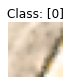

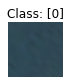

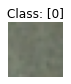

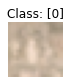

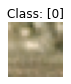

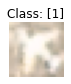

In [0]:
show_images(planelist,X,Y)

# Models

### Creating the Model

The following changes to model architecture and hyperparameters were tested:
*   Adding and subtracting convolutional layers
*   Double-stacking convolutional layers
*   Activation functions: sigmoid, relu, tanh, swish
*   Adding fully-connected layers to latter end of the model

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='swish', input_shape=(20, 20, 3), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='swish', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='swish', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='swish', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='swish', padding='same'))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='swish'))
model.add(layers.Dense(16, activation='swish'))
model.add(layers.Dense(2))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 32)          9

## Compiling and Training the Model

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
# training the model
epochs = 25
test_set = datagen.flow(train_X, train_Y, batch_size=128)
train_set = datagen.flow(train_X, train_Y, batch_size=128)

history = model.fit(test_X,test_Y,
          steps_per_epoch=len(train_X) / 128,
          epochs=epochs,
          validation_data=(train_X,train_Y))

Epoch 1/25
200/200 [==============================] - 2s 12ms/step - loss: 0.5177 - accuracy: 0.7475 - val_loss: 0.3831 - val_accuracy: 0.7677
Epoch 2/25
200/200 [==============================] - 2s 10ms/step - loss: 0.3295 - accuracy: 0.8411 - val_loss: 0.2835 - val_accuracy: 0.8652
Epoch 3/25
200/200 [==============================] - 2s 11ms/step - loss: 0.2536 - accuracy: 0.8906 - val_loss: 0.2231 - val_accuracy: 0.9023
Epoch 4/25
200/200 [==============================] - 2s 11ms/step - loss: 0.2183 - accuracy: 0.9056 - val_loss: 0.2352 - val_accuracy: 0.9007
Epoch 5/25
200/200 [==============================] - 2s 11ms/step - loss: 0.1893 - accuracy: 0.9234 - val_loss: 0.2145 - val_accuracy: 0.9087
Epoch 6/25
200/200 [==============================] - 2s 11ms/step - loss: 0.1566 - accuracy: 0.9373 - val_loss: 0.1386 - val_accuracy: 0.9445
Epoch 7/25
200/200 [==============================] - 2s 10ms/step - loss: 0.1395 - accuracy: 0.9434 - val_loss: 0.1182 - val_accuracy: 0.9543

In [0]:
# Save the entire model as a SavedModel.
#!mkdir -p saved_model
#model.save('drive/My Drive/saved_models/cnn_swisht_9967') 

## Loss and Accuracy

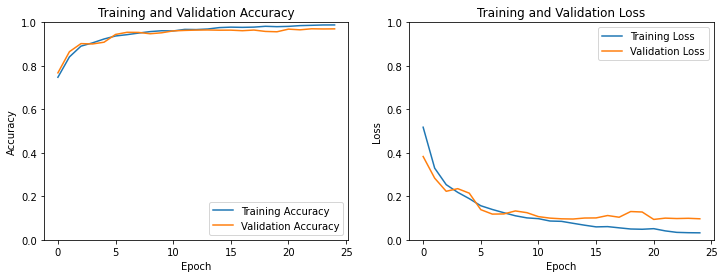

200/200 - 0s - loss: 0.0178 - accuracy: 0.9937


In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0, 1])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

test_loss, test_acc = model.evaluate(test_X,  test_Y, verbose=2)

# Evaluating the model

## Loading a saved model

For purposes of evaluation, we will load the best model obtained through the course of testing.

In [0]:
new_model = tf.keras.models.load_model('drive/My Drive/saved_models/cnn_swish_9875')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 20, 20, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 64)          18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 64)         

In [0]:
# Evaluate the restored model
loss, acc = new_model.evaluate(test_X,  test_Y, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

200/200 - 0s - loss: 0.0605 - accuracy: 0.9875
Restored model, accuracy: 98.75%


## Confusion Matrix

Of the 1600 "plane" images, 1555 were correctly classified and 45 incorrectly classified (97.19% correct). Of the 4800 "no plane" images, 4765 were correctly classified, and 35 were incorrectly classified (99.27% correct).

In [0]:
# calculate probabilities given by the model, convert into model predictions

y_pred = np.argmax(new_model.predict(test_X), axis=-1)

In [0]:
# confusion matrix for the model

metrics.confusion_matrix(test_Y, y_pred, labels=None, sample_weight=None,
                     normalize=None)

array([[4765,   35],
       [  45, 1555]])

## Visualizing Misclassifications

Visualizations of the misclassified images suggest that the model was confused by images that are very faint or grainy--where it is difficult to pick out airplanes with the naked eye--as well as some images without planes have light-colored linear features.

In [0]:
# accuracy gives true = misclassified, false = properly classified
inaccuracy = (y_pred != test_Y.squeeze())
# pulls indices of entries that are misclassified
misclassified = np.where(inaccuracy)[0]
miscl_ind = random_images(20,misclassified)

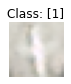

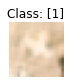

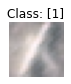

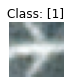

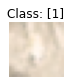

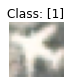

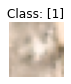

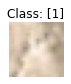

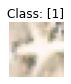

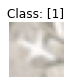

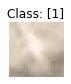

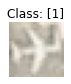

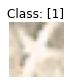

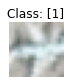

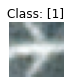

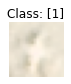

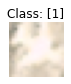

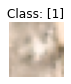

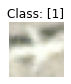

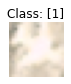

In [0]:
# a selection of images that were misclassified
show_images(miscl_ind, test_X, test_Y)

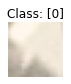

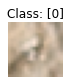

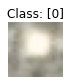

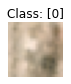

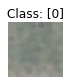

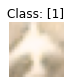

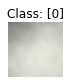

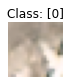

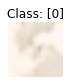

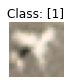

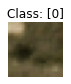

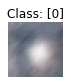

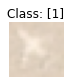

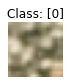

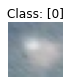

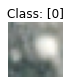

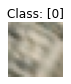

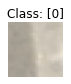

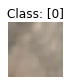

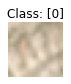

In [0]:
# indices of the test images correctly classified
correct = [x for x in range(0,6400) if x not in misclassified]

# randomly select 20 of the properly classified images to view
correct_ind = random_images(20,correct)

# show correctly classified images
show_images(correct_ind, test_X, test_Y)

# Appendix I: Preliminary Analysis, Unsupervised Methods

## Principle Component Analysis

References:
*   [PCA using Python](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60), Michael Galarnyk


### Data Preparation

In [0]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

planes_df = pd.DataFrame(data)

In [0]:
# convert Y into a list of labels, X into an array of data
labels = Y.squeeze()
labels = pd.DataFrame(labels, columns = ['class'])
planes_data = X.reshape([-1,1200])

In [0]:
# scale data
scaled_data =StandardScaler().fit_transform(planes_data)

### PCA Projection to 2D

In [0]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_data)

In [0]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf.head(5)

,principal component 1,principal component 2
0,-14.160902,1.808370
1,-25.341062,-8.784497
2,-24.603480,1.642884
3,-0.434849,-3.733488
4,-11.353775,4.032580


In [0]:
finalDf = pd.concat([principalDf, labels], axis = 1)
finalDf.head(5)

,principal component 1,principal component 2,class
0,-14.160902,1.808370,1
1,-25.341062,-8.784497,1
2,-24.603480,1.642884,1
3,-0.434849,-3.733488,1
4,-11.353775,4.032580,1


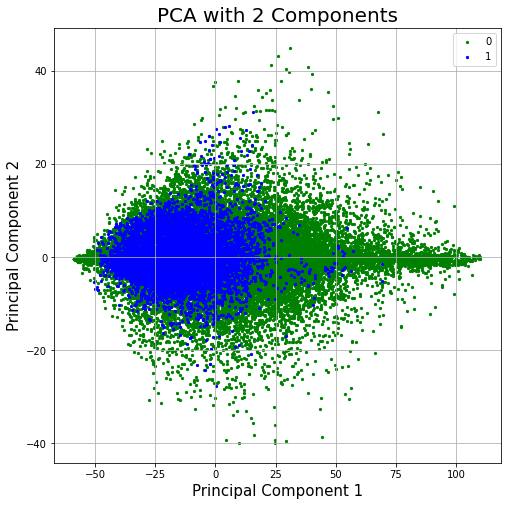

In [0]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA with 2 Components', fontsize = 20)

targets = [0, 1]
colors = ['g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 5)
ax.legend(targets)
ax.grid()

In [0]:
# Shows that the two principle components account for 72.22% of the total variance
pca.explained_variance_ratio_

array([0.6841226 , 0.03798394])

## K-means Clustering

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [0]:
kmeans = KMeans(n_clusters=2, max_iter=300, random_state=0)
kmeans.fit(planes_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [0]:
y_pred = kmeans.predict(planes_data)

In [0]:
labels_list = list(labels['class'])

print(confusion_matrix(labels_list, y_pred))

print('Accuracy: ' + str(accuracy_score(labels_list, y_pred)))

[[ 9864 14136]
 [  494  7506]]
Accuracy: 0.5428125


# Appendix II: Preliminary Analysis, Supervised Methods

## Logistic Regression

*   [Logistic Regression using Python](https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a), Michael Galarnyk

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(planes_data, labels_list, test_size=0.2, random_state=511)
xscaled_train, xscaled_test, yscaled_train, yscaled_test = train_test_split(scaled_data, labels_list, test_size=0.2, random_state=917)

In [0]:
logisticRegr = LogisticRegression(max_iter=4000)
logisticRegr.fit(xscaled_train, yscaled_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = logisticRegr.predict(xscaled_test)
print(confusion_matrix(yscaled_test, y_pred))
print('Accuracy: ' + str(accuracy_score(yscaled_test, y_pred)))

[[4572  274]
 [ 274 1280]]
Accuracy: 0.914375


## Linear and Quadratic Discriminant Analysis (LDA/QDA)

Resources:

*   [Implementing LDA in Python with Scikit-Learn](https://stackabuse.com/implementing-lda-in-python-with-scikit-learn/), Usman Malik


First, we will perform the LDA.


In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [0]:
lda = LDA(n_components=1)
lda.fit(x_train,y_train)

LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [0]:
y_pred = lda.predict(x_test)
print(y_pred)

[0 0 1 ... 0 0 0]


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test, y_pred))

print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

[[4517  310]
 [ 316 1257]]
Accuracy: 0.9021875


Next, compare to the results given by QDA.

In [0]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [0]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train,y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [0]:
y_pred = qda.predict(x_test)
print(y_pred)

[0 0 1 ... 0 1 0]


In [0]:
print(confusion_matrix(y_test, y_pred))

print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

[[4362  465]
 [ 364 1209]]
Accuracy: 0.87046875



## Support Vector Machines (SVM)

Resources:
*   [Support Vector Machines with Scikit-learn](https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python), Avinash Navlani

In [0]:
from sklearn import svm

#Create a svm Classifier
svm = svm.SVC() # Linear Kernel  linear, polynomial, and radial kernels possible
svm.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_pred = svm.predict(x_test)
print(y_pred)

[0 0 1 ... 0 0 0]


In [0]:
print(confusion_matrix(y_test, y_pred))

print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

[[4723  104]
 [ 163 1410]]
Accuracy: 0.95828125


## Tree-based classifications

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier(max_depth=2, random_state=0)

randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_test)

In [0]:
print(confusion_matrix(y_test, y_pred))

print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

[[4476  351]
 [ 440 1133]]
Accuracy: 0.87640625


# References

* [Planes in Satellite Imagery](https://www.kaggle.com/rhammell/planesnet), R. Hammell
*	[Keras Applications](https://keras.io/api/applications/)
*	[CS231n: Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/) (Stanford University)
*	[TensorFlow Image Classification Tutorial](https://www.tensorflow.org/tutorials/images/classification)
